In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

import warnings
warnings.simplefilter('ignore')

SEED = 42

In [2]:
df = pd.read_csv('df_complete.csv')
df.head()

,Laureate name,Title,Is prize-winning paper,p-value,Gender,field,citation_count,citation_percentile,nobel_citation_percentile,Pub year
0,"stoddart, j",a molecular shuttle,YES,0.250622,male,Chemistry,667.0,0.981743,0.981743,1991.0
1,"stoddart, j",chemical synthesis of nanostructures,NO,0.250622,male,Chemistry,1.0,0.156846,0.981743,1993.0
2,"stoddart, j",formation and x ray crystal structure of pt h2...,NO,0.250622,male,Chemistry,10.0,0.257676,0.981743,1981.0
3,"stoddart, j",single walled carbon nanotubes under the influ...,NO,0.250622,male,Chemistry,87.0,0.736515,0.981743,2005.0
4,"stoddart, j",synthesis of medium heterocyclic rings from 6 ...,NO,0.250622,male,Chemistry,6.0,0.219087,0.981743,1974.0


In [3]:
df = df[df['Is prize-winning paper'] == 'YES']

labels = ['<0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1']
df['p bin'] = pd.cut(df['p-value'], bins=10, labels=labels)
df.head()

,Laureate name,Title,Is prize-winning paper,p-value,Gender,field,citation_count,citation_percentile,nobel_citation_percentile,Pub year,p bin
0,"stoddart, j",a molecular shuttle,YES,0.250622,male,Chemistry,667.0,0.981743,0.981743,1991.0,0.2-0.3
1205,"feringa, b",light driven monodirectional molecular rotor,YES,0.524845,male,Chemistry,1689.0,1.000000,1.000000,1999.0,0.5-0.6
1527,"sauvage, j",une nouvelle famille de molecules les metallo ...,YES,0.047244,male,Chemistry,667.0,0.994751,0.994751,1983.0,<0.1
1908,"modrich, p",dna mismatch correction in a defined system,YES,0.196429,male,Chemistry,419.0,0.937500,0.937500,1989.0,0.1-0.2
2020,"lindahl, t",an n glycosidase from escherichia coli that re...,YES,0.133333,male,Chemistry,438.0,0.866667,0.866667,1974.0,0.1-0.2


In [7]:
features = ['p-value', 'field']
df_encoded = pd.get_dummies(df[features], drop_first=True)
df_encoded['citation_percentile'] = df['citation_percentile']
df_encoded['p-value'] = df['p-value']
features = list(df_encoded.drop(columns=['citation_percentile']).columns)

lm = LinearRegression()
lm.fit(df_encoded[features], df['citation_percentile'])
print(f'Coefficients: {lm.coef_}')
print(f'Intercept: {lm.intercept_}')
print(f'R^2 score: {lm.score(df_encoded[features], df["citation_percentile"])}')

Coefficients: [-0.00095865 -0.00452064 -0.01198596]
Intercept: 0.9325836860743755
R^2 score: 0.0008807638659749095


In [18]:
# Baseline XGB
# This uses only p-value
xgb = XGBRegressor(
    enable_categorical=True,
    random_state=SEED
)
xgb.fit(df_encoded['p-value'], df_encoded['citation_percentile'])
citation_preds = xgb.predict(df_encoded['p-value'])
r2 = xgb.score(df_encoded['p-value'], df_encoded['citation_percentile'])
print(f'R^2: {r2}')

R^2: 0.31568291036596274


In [20]:
features = ['p-value', 'field']

In [21]:
df1 = df[features]
cat_features = ['field']
df1['citation_percentile'] = df['citation_percentile']
df1[cat_features] = df1[cat_features].astype('category')
df1 = df1.dropna()
df1.head()

,p-value,field,citation_percentile
0,0.250622,Chemistry,0.981743
1205,0.524845,Chemistry,1.000000
1527,0.047244,Chemistry,0.994751
1908,0.196429,Chemistry,0.937500
2020,0.133333,Chemistry,0.866667


In [23]:
xgb = XGBRegressor(
    enable_categorical=True,
    random_state=SEED
    )
xgb.fit(df1[features], df1['citation_percentile'])
citation_preds = xgb.predict(df1[features])
# r2 = xgb.score(df1[features], df1['citation_percentile'])
r2 = r2_score(df1['citation_percentile'], citation_preds)
print(f'R^2: {r2}')

R^2: 0.5402261828653212


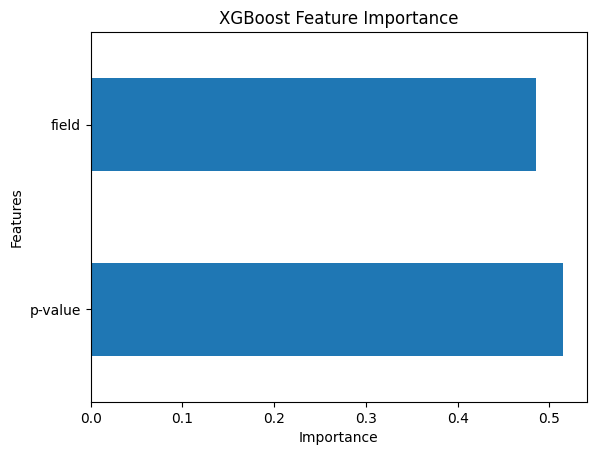

In [ ]:
# prompt: get the most important features from the xgboost model and plot it

feat_importances = pd.Series(xgb.feature_importances_, index=features)
feat_importances.nlargest(len(features)).plot(kind='barh')
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

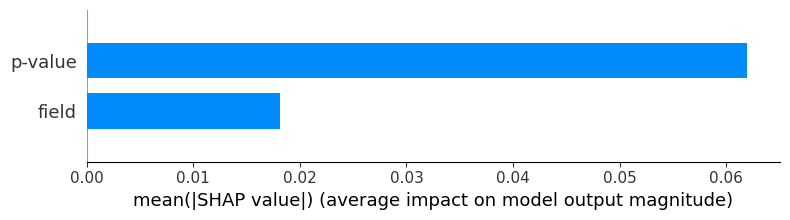

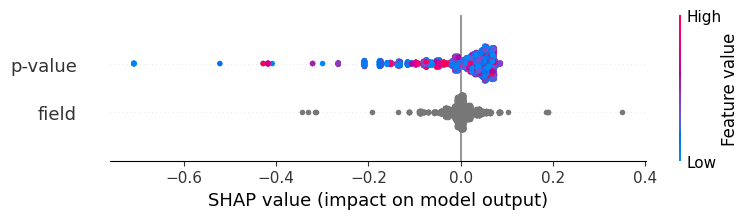

In [ ]:
# shap plot
import shap
explainer = shap.Explainer(xgb)
shap_values = explainer(df1[features])
shap.summary_plot(shap_values, df1[features], plot_type="bar")
shap.summary_plot(shap_values, df1[features])

## XGB With Cross Validation

In [38]:
def xgb_cv(df, params, features, n_splits=10):
    """
    Performs 10-fold cross-validation for XGBoost on a given dataframe.

    Args:
        df (pd.DataFrame): The input dataframe. Must contain 'citation_percentile' and feature columns.
        params (dict): Parameters for the XGBoost Regressor.
        n_splits (int): The number of folds for cross-validation. Defaults to 10.

    Returns:
        tuple: A tuple containing the list of R^2 scores for each fold and the average R^2 score.
    """
    X = df[features]
    y = df['citation_percentile']

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    r2_scores = []
    train_r2_scores = []

    for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
        print(f"Fold {fold+1}/{n_splits}")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        xgb_model = XGBRegressor(
            **params
            )
        xgb_model.fit(X_train, y_train)
        train_pred = xgb_model.predict(X_train)
        train_r2 = r2_score(y_train, train_pred)
        train_r2_scores.append(train_r2)
        print(f"Train R^2: {train_r2}")
        y_pred = xgb_model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)
        print(f"Fold {fold+1} R^2: {r2}")

    avg_r2 = np.mean(r2_scores)
    avg_train_r2 = np.mean(train_r2_scores)
    print(f"\nAverage Train R^2: {avg_train_r2}")
    print(f"\nAverage R^2 over {n_splits} folds: {avg_r2}")

    return r2_scores, avg_r2


In [26]:
params = {
    'random_state': SEED,
    'enable_categorical': True
}

In [39]:
# Cross validation for only p-value
r2_scores, avg_r2 = xgb_cv(df=df1, params=params, features=['p-value'])

Fold 1/10
Train R^2: 0.3619129166947589
Fold 1 R^2: -0.043471642485749085
Fold 2/10
Train R^2: 0.3216014031885913
Fold 2 R^2: 0.12356024490320028
Fold 3/10
Train R^2: 0.3344523632159814
Fold 3 R^2: -0.3452068556260204
Fold 4/10
Train R^2: 0.3339797575763206
Fold 4 R^2: -0.11246499984851699
Fold 5/10
Train R^2: 0.3506565597483735
Fold 5 R^2: -0.3600452464794932
Fold 6/10
Train R^2: 0.3241184584536795
Fold 6 R^2: -0.29249212660729773
Fold 7/10
Train R^2: 0.3655627461133266
Fold 7 R^2: -0.699780227762798
Fold 8/10
Train R^2: 0.3693229049104625
Fold 8 R^2: -0.345470176358325
Fold 9/10
Train R^2: 0.3736875455663161
Fold 9 R^2: -0.5534108083760778
Fold 10/10
Train R^2: 0.3545273769611277
Fold 10 R^2: -0.10880045354685985

Average Train R^2: 0.3489822032428938

Average R^2 over 10 folds: -0.2737582292187938


In [40]:
# Cross validation for only p-value
r2_scores, avg_r2 = xgb_cv(df=df1, params=params, features=['p-value', 'field'])

Fold 1/10
Train R^2: 0.5555313462961857
Fold 1 R^2: -0.13036453716212404
Fold 2/10
Train R^2: 0.5438107145997181
Fold 2 R^2: 0.11324722630951445
Fold 3/10
Train R^2: 0.5590388040184626
Fold 3 R^2: -0.020502277469739205
Fold 4/10
Train R^2: 0.5262403374005766
Fold 4 R^2: -0.17293805233725545
Fold 5/10
Train R^2: 0.5190683208317527
Fold 5 R^2: -0.295714143825645
Fold 6/10
Train R^2: 0.5306960843366926
Fold 6 R^2: -0.5664509683283572
Fold 7/10
Train R^2: 0.5896383941528169
Fold 7 R^2: -0.7127076858184691
Fold 8/10
Train R^2: 0.5426250435037155
Fold 8 R^2: -0.4239895911056055
Fold 9/10
Train R^2: 0.5623789090627118
Fold 9 R^2: -0.5584906369542864
Fold 10/10
Train R^2: 0.5682890572917065
Fold 10 R^2: -0.1553748440571452

Average Train R^2: 0.5497317011494339

Average R^2 over 10 folds: -0.29232855107491124


In [44]:
features = ['p-value', 'field']
df_encoded = pd.get_dummies(df[features], drop_first=True)
df_encoded['citation_percentile'] = df['citation_percentile']
df_encoded['p-value'] = df['p-value']
features = list(df_encoded.drop(columns=['citation_percentile']).columns)

In [46]:
# prompt: make a function for 10 fold cross validation with a linear regression model. It should output training and testing r^2 value

def linear_regression_cv(df, features, n_splits=10):
  """
  Performs 10-fold cross-validation for Linear Regression on a given dataframe.

  Args:
    df (pd.DataFrame): The input dataframe. Must contain 'citation_percentile' and feature columns.
    features (list): A list of feature column names to use.
    n_splits (int): The number of folds for cross-validation. Defaults to 10.

  Returns:
    tuple: A tuple containing the list of R^2 scores for each fold and the average R^2 score.
  """
  X = df_encoded[features]
  y = df_encoded['citation_percentile']

  kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
  test_r2_scores = []
  train_r2_scores = []

  for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    print(f"Fold {fold+1}/{n_splits}")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lm_model = LinearRegression()
    lm_model.fit(X_train, y_train)

    # Calculate training R^2
    train_pred = lm_model.predict(X_train)
    train_r2 = r2_score(y_train, train_pred)
    train_r2_scores.append(train_r2)
    print(f"Train R^2: {train_r2}")

    # Calculate testing R^2
    test_pred = lm_model.predict(X_test)
    test_r2 = r2_score(y_test, test_pred)
    test_r2_scores.append(test_r2)
    print(f"Test R^2: {test_r2}")

  avg_train_r2 = np.mean(train_r2_scores)
  avg_test_r2 = np.mean(test_r2_scores)
  print(f"\nAverage Train R^2: {avg_train_r2}")
  print(f"\nAverage Test R^2 over {n_splits} folds: {avg_test_r2}")

  return train_r2_scores, test_r2_scores, avg_train_r2, avg_test_r2

# Example usage with the linear regression function:
print("\nLinear Regression Cross Validation:")
# Assuming df_encoded is the DataFrame with one-hot encoded features
train_r2_scores_lm, test_r2_scores_lm, avg_train_r2_lm, avg_test_r2_lm = linear_regression_cv(df=df_encoded, features=features)



Linear Regression Cross Validation:
Fold 1/10
Train R^2: 0.0002913367815611245
Test R^2: 0.002938429202428927
Fold 2/10
Train R^2: 0.0009820829826365784
Test R^2: -0.010448373504264863
Fold 3/10
Train R^2: 0.00018166672258879135
Test R^2: -0.0020093940538201682
Fold 4/10
Train R^2: 0.0013210485135789485
Test R^2: -0.011651148219772534
Fold 5/10
Train R^2: 0.0003547406155022248
Test R^2: -0.0015816304457318964
Fold 6/10
Train R^2: 0.0025009825463576663
Test R^2: -0.04398765012255179
Fold 7/10
Train R^2: 0.0020881489098221184
Test R^2: -0.019519192270570862
Fold 8/10
Train R^2: 0.0018355115061352567
Test R^2: -0.02669669987611689
Fold 9/10
Train R^2: 0.0012746098735245681
Test R^2: -0.009118750735119363
Fold 10/10
Train R^2: 0.001566420558578252
Test R^2: -0.020060059798139518

Average Train R^2: 0.001239654901028553

Average Test R^2 over 10 folds: -0.014213446982365896
